# Keystroke Dynamics

The datasets:

*   http://www3.cs.stonybrook.edu/~rbanerjee/project-pages/keystrokes/keystrokes.html


In [1]:
import pandas as pd
import numpy as np
import sklearn
import altair as alt
import matplotlib.pyplot as plt
import os
import tabulate
import seaborn as sns

sns.set()

In [2]:
alt.data_transformers.enable('default', max_rows=None) 
# alt.renderers.enable('default')
# alt.renderers.enable('notebook')

DataTransformerRegistry.enable('default')

# 1. Data Preparation

In [3]:
# Save temp altair json files in separate folder
os.makedirs('tmp/altdata', exist_ok=True)

def custom(data):
    return alt.pipe(data, alt.to_json(filename='tmp/altdata/{prefix}-{hash}.{extension}') )

alt.data_transformers.register('custom', custom)
alt.data_transformers.enable('custom')

DataTransformerRegistry.enable('custom')

### ! Before executing this code, make sure you've downloaded the datasets by the link and unpacked csv files to `data` directory

In [4]:
files = ('data/ReviewAMT_500_t.csv', 'data/GayMarriage_400.csv', 'data/GunControl_400.csv')
df_atm = pd.read_csv(files[0], sep='\t')
df_gay = pd.read_csv(files[1], sep='\t')
df_gun = pd.read_csv(files[2], sep='\t')

In [5]:
df_atm.rename(columns = {'ReviewTopic': 'Topic'}, inplace=True)
df_atm['Task'] = df_atm['Task'].map(
    {
        "Fake Review": 'fake', 
        "True Review": 'true',
        'Copy_1': 'copy_1',
        'Copy_2': 'copy_2'
    }) 
df_atm.head(3)

,UserName,AccessKey,ReviewDate,Topic,Task,Group,Flow,Restaurant,Addr,Site,ReviewText,ReviewMeta
0,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,Sun Jun 02 20:55:38 UTC 2013,AMT,copy_1,AMT,TF,NaN,NaN,NaN,Famous Daves is a good place to go for some go...,0 MouseUp 0 0;535 KeyDown 16;776 KeyDown 70;79...
1,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,Sun Jun 02 20:58:33 UTC 2013,AMT,copy_2,AMT,TF,NaN,NaN,NaN,The Original Shrimp Place is a good place to c...,0 MouseUp 0 0;491 KeyDown 16;778 KeyDown 84;82...
2,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,Sun Jun 02 20:53:01 UTC 2013,AMT,fake,AMT,TF,The Original Shrimp Place,NaN,NaN,The Original Shrimp Place is a good place to c...,0 MouseUp 0 0;849 KeyDown 16;966 KeyDown 84;10...


In [231]:
df_gay['Task'] = df_gay['Task'].map(
    {
        "Fake Essay": 'fake', 
        "True Essay": 'true',
        'Copy_1': 'copy_1',
        'Copy_2': 'copy_2'
    }) 
df_gay.head(3)

,UserName,AccessKey,Topic,Opinion,ReviewDate,ReviewType,Task,Group,Flow,ReviewText,ReviewMeta
0,A12WI1MRO70881,81a90739642349eb8f130f4e8f5e8deb,Gay Marriage,support,Thu May 30 04:08:13 UTC 2013,AMT,copy_1,AMT,FT,Gay Marriage is an oxymoron even as a concept....,0 MouseUp 0 0;878 MouseUp 0 0;1691 MouseUp 0 0...
1,A12WI1MRO70881,81a90739642349eb8f130f4e8f5e8deb,Gay Marriage,support,Thu May 30 04:14:38 UTC 2013,AMT,copy_2,AMT,FT,Marriage is about love and commitment. Its a ...,0 MouseUp 0 0;762 KeyDown 16;1160 KeyDown 77;1...
2,A12WI1MRO70881,81a90739642349eb8f130f4e8f5e8deb,Gay Marriage,support,Thu May 30 03:44:09 UTC 2013,AMT,fake,AMT,FT,Gay Marriage is an oxymoron even as a concept....,0 MouseUp 0 0;860 MouseUp 0 0;1722 MouseUp 0 0...


In [6]:
df_gun['Task'] = df_gun['Task'].map(
    {
        "Fake Essay": 'fake', 
        "True Essay": 'true',
        'Copy_1': 'copy_1',
        'Copy_2': 'copy_2'
    }) 
df_gun.head(3)

,UserName,AccessKey,Topic,Opinion,ReviewDate,ReviewType,Task,Group,Flow,ReviewText,ReviewMeta
0,A10E8QHPV30BAD,0102f02e052a473f8b5a87f42a9f6c13,Gun Control,oppose,Sat Jun 15 14:09:11 UTC 2013,AMT,copy_1,AMT,FT,I strongly support gun control being strongly ...,0 MouseUp 0 0;5309 KeyDown 16;5453 KeyDown 73;...
1,A10E8QHPV30BAD,0102f02e052a473f8b5a87f42a9f6c13,Gun Control,oppose,Sat Jun 15 14:11:57 UTC 2013,AMT,copy_2,AMT,FT,I strongly oppose gun control as I believe it ...,0 MouseUp 0 0;874 KeyDown 16;946 KeyDown 73;10...
2,A10E8QHPV30BAD,0102f02e052a473f8b5a87f42a9f6c13,Gun Control,oppose,Sat Jun 15 14:01:32 UTC 2013,AMT,fake,AMT,FT,I strongly support gun control being strongly ...,0 MouseUp 0 0;5023 KeyDown 91;5517 KeyDown 91;...


### Lets concat three datasets and leave only 5 columns

In [7]:
datasets = (df_atm, df_gay, df_gun)
df = pd.concat(
    (dataset[[
        'UserName', 
        'AccessKey', 
        'Topic', 
        'Task',
        'ReviewText', 
        'ReviewMeta'
    ]] for dataset in datasets),
    ignore_index=True)
df.head()

,UserName,AccessKey,Topic,Task,ReviewText,ReviewMeta
0,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,AMT,copy_1,Famous Daves is a good place to go for some go...,0 MouseUp 0 0;535 KeyDown 16;776 KeyDown 70;79...
1,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,AMT,copy_2,The Original Shrimp Place is a good place to c...,0 MouseUp 0 0;491 KeyDown 16;778 KeyDown 84;82...
2,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,AMT,fake,The Original Shrimp Place is a good place to c...,0 MouseUp 0 0;849 KeyDown 16;966 KeyDown 84;10...
3,A002160837SWJFPIAI7L7,392aa3e372054948a5cabd637b2e239b,AMT,true,Famous Daves is a good place to go for some go...,0 MouseUp 0 0;6347 KeyDown 16;6443 KeyDown 70;...
4,A0436270XG2E3RS5T61O,2746b106ea6e42efb6104f45d6b2360c,AMT,copy_1,"Being a big admirer of Italian food, I conside...",0 MouseUp 0 0;597 KeyDown 17;1093 KeyDown 17;1...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserName    5200 non-null   object
 1   AccessKey   5200 non-null   object
 2   Topic       5200 non-null   object
 3   Task        5200 non-null   object
 4   ReviewText  5200 non-null   object
 5   ReviewMeta  5200 non-null   object
dtypes: object(6)
memory usage: 243.9+ KB


### As a result, we have 1060 unique users:

In [9]:
len(df['UserName'].unique())

1060

In [56]:
len(df['AccessKey'].unique())

1300

In [57]:
df['Task'].unique()

array(['copy_1', 'copy_2', 'fake', 'true'], dtype=object)

### Lets save the data into file

In [9]:
df.to_csv(r'data/merged_datasets.csv', sep='\t')

# 2. Data Investigation

In [10]:
df['ReviewMeta'][59][0:400]

'0 MouseUp 0 0;16705 KeyDown 16;17170 KeyDown 16;17200 KeyDown 16;17229 KeyDown 16;17258 KeyDown 16;17287 KeyDown 16;17317 KeyDown 16;17346 KeyDown 16;17375 KeyDown 16;17404 KeyDown 16;17433 KeyDown 16;17463 KeyDown 16;17492 KeyDown 16;17521 KeyDown 16;17552 KeyDown 16;17580 KeyDown 16;17609 KeyDown 16;17630 KeyDown 73;17717 KeyUp 73;17925 KeyUp 16;18397 KeyDown 32;18528 KeyUp 32;18567 KeyDown 87;1'

### We will build two datasets: `df_dwells` and `df_transitions`. 

`dwells` will hold the times between each `KeyDown` and `KeyUp` events. 
The `transitions` dataset will represent `time` measure ('down-down time') – the time between previous key was down till the next key is down. (always positive).

In [29]:
def process_keystroke(line):
    res = line.split(' ')
    if len(res) > 3:
        return f'UNKNOWN: {line}'
    
    time, command, key = res
    return (time, command, key, chr(int(key)))

def code_to_str(keycode):
    keycode = int(keycode)
    mappings = {
        16: 'shift',
        8: 'backspace',
        32: 'space',
        188: 'comma',
        190: 'dot'
    }
    return mappings.get(keycode, chr(keycode))

vcode_to_str = np.vectorize(code_to_str)

def process_keystrokes(inputs, user_id, attempt_id, task_name):
    def data_row(time, code):
        return [ user_id,  time,  command,  code, attempt_id, task_name ]
    
    def dwell_row(time, code):
        return [ user_id,  time,  code, attempt_id, task_name ] 
    
    def transition_row(time, code1, code2):
        return [ user_id,  time,  code1, code2, attempt_id, task_name ]
            
    MOUSE_UP = 'MouseUp'
    KEY_DOWN = 'KeyDown'
    KEY_UP = 'KeyUp'
    result = []
    dwells = []
    transitions = []
    key_downs = {}
    key_ups = {}
    attempt_id = int(attempt_id)
    last_key_up = None
    last_key_down = None
    
    for keystroke in inputs.split(';'):
        res = keystroke.split(' ')
        
        if len(res) < 3:
            continue
            
        if res[1] == 'MouseUp':
            continue

        time, command, code = res
        time = int(time)
        code = int(code)
        
        if command == KEY_DOWN:
            key_downs[code] = time
            
            if last_key_down:
                last_down_code, last_down_time = last_key_down
                timeshift = time - last_down_time 
                transitions.append(transition_row(timeshift, last_down_code, code))
                
            last_key_down = [code, time]
            
        if command == KEY_UP:
            if code in key_downs:
                timeshift = time - key_downs[code]
                dwells.append(dwell_row(timeshift, code))
                del key_downs[code]
                last_key_up = [code, time]
            
        result.append(data_row(time, code))
        
    return result, dwells, transitions

vprocess_keystrokes = np.vectorize(process_keystrokes)

def process_data(df):
    results = []
    dwell_data = []
    transitions_data = []
    columns = ['user_id', 'time', 'command', 'code', 'attempt_id', 'task_name']
    for index, inputs in df.iterrows():
        all_keystrokes, dwells, transitions  = process_keystrokes(
            inputs['ReviewMeta'], 
            inputs['UserName'], 
            index, 
            inputs['Task']
        )
        results.extend(all_keystrokes)
        dwell_data.extend(dwells)
        transitions_data.extend(transitions)
    return \
        pd.DataFrame(dwell_data, columns=['user_id', 'time', 'code', 'attempt_id', 'task_name']), \
        pd.DataFrame(results, columns=['user_id', 'time', 'command', 'code', 'attempt_id', 'task_name']), \
        pd.DataFrame(transitions_data, columns=['user_id', 'time', 'code_from', 'code_to', 'attempt_id', 'task_name']) 

In [79]:
df_dwells_raw, df_all_raw, df_transitions_raw = process_data(df)
df_dwells_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568673 entries, 0 to 4568672
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   time        int64 
 2   code        int64 
 3   attempt_id  int64 
 4   task_name   object
dtypes: int64(3), object(2)
memory usage: 174.3+ MB


In [81]:
df_dwells_raw.head(3)

,user_id,time,code,attempt_id,task_name
0,A002160837SWJFPIAI7L7,260,16,0,copy_1
1,A002160837SWJFPIAI7L7,192,70,0,copy_1
2,A002160837SWJFPIAI7L7,127,65,0,copy_1


### Now, add a human interperation of the key code

In [82]:
df_all_raw['key'] = vcode_to_str(df_all_raw['code'])

In [36]:
df_all_raw.head()

,user_id,time,command,code,attempt_id,task_name,key
0,A002160837SWJFPIAI7L7,535,KeyDown,16,0,copy_1,shift
1,A002160837SWJFPIAI7L7,776,KeyDown,70,0,copy_1,F
2,A002160837SWJFPIAI7L7,795,KeyUp,16,0,copy_1,shift
3,A002160837SWJFPIAI7L7,924,KeyDown,65,0,copy_1,A
4,A002160837SWJFPIAI7L7,968,KeyUp,70,0,copy_1,F


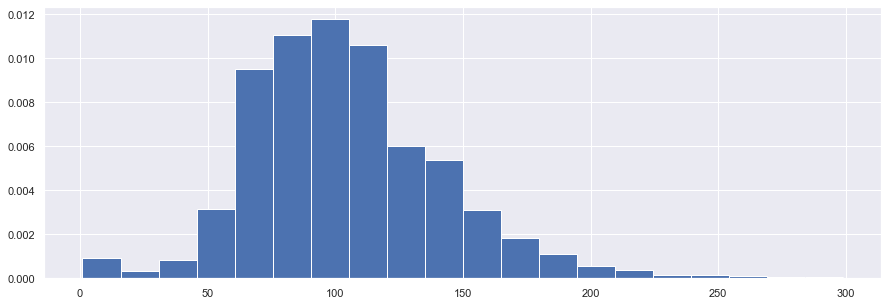

In [84]:
# alt.Chart(df_dwells).mark_bar().encode(
#     alt.X("time:Q", bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Time (ms)')),
#     y=alt.Y('count()', axis=alt.Axis(title=None))
# ).transform_filter(
#     'datum.time > 0 & datum.time < 300'
# ).properties(
#     width=800, title='Dwells time distribution'
# )
plt.figure(figsize=(15, 5))
df_dwells = df_dwells_raw.loc[(df_dwells_raw['time'] > 0) & (df_dwells_raw['time'] < 300)]
plt.hist(df_dwells['time'], bins=20, density=True)
plt.show()

In [85]:
df_dwells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4542191 entries, 0 to 4568672
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   time        int64 
 2   code        int64 
 3   attempt_id  int64 
 4   task_name   object
dtypes: int64(3), object(2)
memory usage: 207.9+ MB


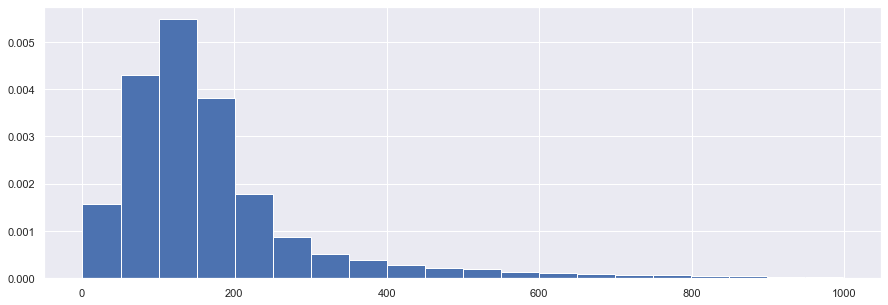

In [187]:
# alt.Chart(df_transitions).mark_bar().encode(
#     alt.X("time:Q", bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Time (ms)')),
#     y=alt.Y('count()', axis=alt.Axis(title=None))
# ).transform_filter(
#     'datum.time > 0 & datum.time < 1700'
# ).properties(width=800, title='Transition time distribution')

plt.figure(figsize=(15, 5))
df_transitions = df_transitions_raw.loc[(df_transitions_raw['time'] > 0) & (df_transitions_raw['time'] < 1000)]
plt.hist(df_transitions['time'], bins=20, density=True)
plt.show()

In [188]:
df_all_raw.groupby('key').count()['command']

key
       115
\t     294

        2
\r    5801
     3711
      ... 
á        2
â        8
é       97
ü     9776
ÿ       38
Name: command, Length: 108, dtype: int64

In [86]:
df_all_raw.head()

,user_id,time,command,code,attempt_id,task_name,key
0,A002160837SWJFPIAI7L7,535,KeyDown,16,0,copy_1,shift
1,A002160837SWJFPIAI7L7,776,KeyDown,70,0,copy_1,F
2,A002160837SWJFPIAI7L7,795,KeyUp,16,0,copy_1,shift
3,A002160837SWJFPIAI7L7,924,KeyDown,65,0,copy_1,A
4,A002160837SWJFPIAI7L7,968,KeyUp,70,0,copy_1,F


In [87]:
df_all_raw.key.unique()

array(['shift', 'F', 'A', 'M', 'O', 'U', 'S', 'space', 'D', 'V', 'E', 'I',
       'G', 'P', 'L', 'backspace', 'C', 'T', 'R', 'Q', 'Y', '¾', 'H', 'N',
       'B', '¼', 'K', 'W', 'º', 'X', 'Þ', 'b', 'n', '`', '¿', '\x90', "'",
       '%', '\x11', 'J', 'Z', '0', '&', '(', '4', '3', '9', '5', '1',
       '\x14', '\t', 'À', '[', '.', '½', '\xad', ';', '2', 'Û', '-', '7',
       '#', 'a', 'k', ']', '\r', '\x12', 'Ü', 'p', 'à', '»', '=', '8',
       '6', ',', 'Ý', '¡', '¨', '©', '¢', '$', 'é', '"', 'z', '{', 'd',
       '', 'e', 'm', 'f', 'â', 'i', 'o', '®', '¯', 'ÿ', '·', '!', 'h',
       '\x1b', 'c', 'á', 'ü', '\x0c', '\x13', '§', '¶', '°'], dtype=object)

In [22]:
def grouped_by_key(df,col):
    values = []
    for index, row in df.iterrows():
        values.append({'key': index, 'counter': int(row[col])})
    return values
grouped_data = grouped_by_key(df_all_raw.groupby('key').count(),'command')
grouped_df = alt.Data(values = grouped_data)

alt.Chart(grouped_df).mark_bar().encode(
 x = 'counter:Q',
 y = alt.Y('key:O', sort = alt.Sort(field = 'counter', order='descending')),
).transform_filter('datum.counter > 2000')

alt.Chart(...)

In [88]:
def chart_for_user(user_id):
    return alt.Chart(df_dwells.loc[df_dwells['user_id'] == user_id]).mark_bar().encode(
        x = alt.X('mean(time):Q', scale=alt.Scale(domain=[0, 200])),
        y = alt.Y('code:O', sort = 'ascending')
    )

In [36]:
# chart_for_user('A12TA2E23C9YGK')

In [37]:
# chart_for_user('A1IAK1JCYVR3R5')

# 3. Feature selection

In [89]:
# chose letters/digraphs you want to see in a final table.
# ascii codes:
# https://theasciicode.com.ar/ascii-control-characters/data-link-escape-ascii-code-16.html
# pop_letters = ['E','A','R','I','O','T','N','S',' ']
pop_letters = [69, 65, 82, 73, 79, 84, 78, 83, 32]
pop_digraphs = ['8_8','69_32','32_84','84_72','32_65','83_32','84_32','72_69','68_32','65_78','73_78','82_69']

### single letter features transformation (df_dwells_new)

In [190]:
# select needed letters to use them as features
pop_letters = ['E','A','R','I','O','T','N','S',' ']
pop_letters_ascii = [ord(letter) for letter in pop_letters]
for i in pop_letters_ascii: print('ascii: ',i,', char: ',chr(i))

ascii:  69 , char:  E
ascii:  65 , char:  A
ascii:  82 , char:  R
ascii:  73 , char:  I
ascii:  79 , char:  O
ascii:  84 , char:  T
ascii:  78 , char:  N
ascii:  83 , char:  S
ascii:  32 , char:   


In [94]:
# chose only needed letters: 
df_dwells_new = df_dwells.loc[df_dwells.code.isin(pop_letters_ascii),:]

In [95]:
# calculate mean, variance, std, skew, count for all letters
df_dwells_new = df_dwells_new.groupby(['user_id','attempt_id','task_name','code']).agg(
    {
        'time': ['mean','var','std','skew','count']    
    }
)#.reset_index()
df_dwells_new

time               \
                                                  mean          var   
user_id          attempt_id task_name code                            
?A1OLRUT93TXWEP? 3200       copy_1    32     12.389381    10.061315   
                                      65     11.130435     2.560386   
                                      69     10.630769     1.517788   
                                      73     11.625000     4.500000   
                                      78     11.000000     3.300000   
...                                                ...          ...   
adi3kioe5mmnx    5199       true      78     89.825000   481.019872   
                                      79     88.415094   663.670537   
                                      82    111.945946  1245.774775   
                                      83     85.583333   873.652482   
                                      84     80.175439   203.504386   

                                                                       
                                                  std      skew count  
user_id          attempt_id task_name code                             
?A1OLRUT93TXWEP? 3200       copy_1    32     3.171958  2.964585   113  
                                      65     1.600121  1.206791    46  
                                      69     1.231986  1.007592    65  
                                      73     2.121320  3.058892    32  
                                      78     1.816590  0.884985    21  
...                                               ...       ...   ...  
adi3kioe5mmnx    5199       true      78    21.932165  0.317589    40  
                                      79    25.761804  0.428188    53  
                                      82    35.295535  0.744839    37  
                                      83    29.557613  1.122089    48  
                                      84    14.265496  0.603521    57  

[46800 rows x 5 columns]

In [96]:
#make one line index out of multiindex
df_dwells_new.columns = list(map('_'.join,df_dwells_new.columns.to_flat_index())) 
# trim _ in the end of df column names
df_dwells_new.columns = [x.strip('_') for x in df_dwells_new.columns.to_list()]


In [97]:
# make columns from values in 'code' 
df_dwells_new = df_dwells_new.unstack('code').reset_index()

In [98]:
# manipulations with indexes
df_dwells_new.columns = list(map('_'.join,[(str(x[1]),x[0]) for x in df_dwells_new.columns.to_flat_index()])) 
df_dwells_new.columns = [x.strip('_') for x in df_dwells_new.columns.to_list()]
df_dwells_new.head()

,user_id,attempt_id,task_name,32_time_mean,65_time_mean,69_time_mean,73_time_mean,78_time_mean,79_time_mean,82_time_mean,...,84_time_skew,32_time_count,65_time_count,69_time_count,73_time_count,78_time_count,79_time_count,82_time_count,83_time_count,84_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,12.389381,11.130435,10.630769,11.625000,11.000000,10.633333,10.840000,...,0.846539,113,46,65,32,21,30,25,38,45
1,?A1OLRUT93TXWEP?,3201,copy_2,12.203390,11.297297,10.612245,10.961538,10.533333,10.942857,10.625000,...,0.483820,118,37,49,26,30,35,24,27,41
2,?A1OLRUT93TXWEP?,3202,fake,12.992063,11.473684,10.964912,11.107143,10.593750,11.078947,10.888889,...,0.364864,126,38,57,28,32,38,27,27,47
3,?A1OLRUT93TXWEP?,3203,true,13.301471,11.666667,10.788235,12.386364,12.333333,11.390244,11.314286,...,0.507174,136,54,85,44,30,41,35,51,56
4,A002160837SWJFPIAI7L7,0,copy_1,95.201613,128.392857,117.779412,94.724138,97.424242,103.725490,121.680000,...,0.374113,124,56,68,29,33,51,25,34,52


In [103]:
df_dwells_new.describe()

,attempt_id,32_time_mean,65_time_mean,69_time_mean,73_time_mean,78_time_mean,79_time_mean,82_time_mean,83_time_mean,84_time_mean,...,84_time_skew,32_time_count,65_time_count,69_time_count,73_time_count,78_time_count,79_time_count,82_time_count,83_time_count,84_time_count
count,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,...,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,2599.500000,105.288669,118.418287,106.936540,104.732716,104.095037,107.833795,107.118944,111.007835,101.147666,...,0.262936,144.307500,55.355192,80.220577,46.701538,43.871731,50.557115,38.264038,40.709423,59.396346
std,1501.255031,25.770125,29.387363,26.225703,26.522019,26.323436,27.351042,26.288436,27.664406,25.219119,...,0.762111,49.619439,21.327464,29.724593,19.282119,19.153340,20.566880,16.031144,16.786738,23.357735
min,0.000000,4.268293,6.977273,5.690141,6.244444,5.869565,6.307692,6.153846,6.071429,6.410714,...,-3.191160,75.000000,16.000000,30.000000,14.000000,15.000000,17.000000,11.000000,12.000000,23.000000
25%,1299.750000,88.995935,100.721806,90.621429,87.546827,87.409147,90.484666,90.910014,93.000000,85.146861,...,-0.187840,114.000000,42.000000,63.000000,35.000000,32.000000,38.000000,28.000000,30.000000,45.000000
50%,2599.500000,104.668116,118.647059,106.217021,103.726190,103.166447,107.175238,106.880442,110.641941,99.960299,...,0.209166,128.000000,51.000000,73.000000,42.000000,40.000000,46.000000,35.000000,37.000000,53.000000
75%,3899.250000,121.132968,136.593483,123.329664,121.456583,119.047628,125.784266,123.698810,128.126683,116.694669,...,0.642154,155.000000,62.000000,88.000000,53.000000,50.000000,57.000000,44.000000,46.000000,66.000000
max,5199.000000,208.808642,229.870968,207.120000,200.500000,201.588235,198.250000,195.629630,220.763158,192.244444,...,5.887025,610.000000,296.000000,390.000000,265.000000,215.000000,232.000000,207.000000,209.000000,295.000000


### digraph features transformations (df_transitions_final)

In [191]:
df_transitions.head()

,user_id,time,code_from,code_to,attempt_id,task_name
0,A002160837SWJFPIAI7L7,241,16,70,0,copy_1
1,A002160837SWJFPIAI7L7,148,70,65,0,copy_1
2,A002160837SWJFPIAI7L7,101,65,77,0,copy_1
3,A002160837SWJFPIAI7L7,241,77,79,0,copy_1
4,A002160837SWJFPIAI7L7,103,79,85,0,copy_1


In [106]:
def char_converter(x):
    if x == 8 : return 'backspace'
    elif x == 14 or x== 15 : return 'shift'
    elif x == 32 : return 'space'
    elif x == 16 : return 'DLE'
    else: return chr(x)

In [192]:
# create new columns that combines code_from and code_to columns
df_transitions.loc[:,'code_from_l'] = df_transitions.code_from.apply(lambda x: char_converter(x))
df_transitions.loc[:,'code_to_l'] = df_transitions.code_to.apply(lambda x: char_converter(x))
df_transitions.loc[:,'codes_letters'] = df_transitions["code_from_l"].astype(str) + '_' + df_transitions["code_to_l"].astype(str)
df_transitions.loc[:,'codes'] = df_transitions["code_from"].astype(str) + '_' + df_transitions["code_to"].astype(str)

df_transitions.head()

,user_id,time,code_from,code_to,attempt_id,task_name,code_from_l,code_to_l,codes_letters,codes
0,A002160837SWJFPIAI7L7,241,16,70,0,copy_1,DLE,F,DLE_F,16_70
1,A002160837SWJFPIAI7L7,148,70,65,0,copy_1,F,A,F_A,70_65
2,A002160837SWJFPIAI7L7,101,65,77,0,copy_1,A,M,A_M,65_77
3,A002160837SWJFPIAI7L7,241,77,79,0,copy_1,M,O,M_O,77_79
4,A002160837SWJFPIAI7L7,103,79,85,0,copy_1,O,U,O_U,79_85


In [193]:
# visualize digraphs frequencies
grouped_data_digraphs = grouped_by_key(df_transitions.groupby('codes_letters').count(),'task_name')
grouped_df_digraphs = alt.Data(values = grouped_data_digraphs)

alt.Chart(grouped_df_digraphs).mark_bar().encode(
 x = 'counter:Q',
 y = alt.Y('key:O', sort = alt.Sort(field = 'counter', order='descending')),
).transform_filter('datum.counter > 10000')

alt.Chart(...)

In [194]:
grouped_data_digraphs2 = grouped_by_key(df_transitions.groupby('codes').count(),'task_name')
grouped_df_digraphs2 = alt.Data(values = grouped_data_digraphs2)

alt.Chart(grouped_df_digraphs2).mark_bar().encode(
 x = 'counter:Q',
 y = alt.Y('key:O', sort = alt.Sort(field = 'counter', order='descending')),
).transform_filter('datum.counter > 10000')

alt.Chart(...)

In [195]:
# pop_digraphs = ['8_8','69_32','32_84','84_72','32_65','83_32','84_32','72_69','68_32','65_78','73_78','82_69']
df_transitions_new = df_transitions.loc[df_transitions['codes'].isin(pop_digraphs),:]

In [196]:
df_transitions_new.head()

,user_id,time,code_from,code_to,attempt_id,task_name,code_from_l,code_to_l,codes_letters,codes
6,A002160837SWJFPIAI7L7,404,83,32,0,copy_1,S,space,S_space,83_32
13,A002160837SWJFPIAI7L7,77,83,32,0,copy_1,S,space,S_space,83_32
16,A002160837SWJFPIAI7L7,65,83,32,0,copy_1,S,space,S_space,83_32
17,A002160837SWJFPIAI7L7,541,32,65,0,copy_1,space,A,space_A,32_65
23,A002160837SWJFPIAI7L7,94,68,32,0,copy_1,D,space,D_space,68_32


In [197]:
# calculate mean, variance, std, skew, count for all digraphs
df_transitions_final = df_transitions_new.loc[:,['user_id','time','attempt_id','task_name','codes']].groupby(
    ['user_id','attempt_id','task_name','codes']
    ).agg(
        {
            'time': ['mean','var','std','skew', 'count']
        }
    )#.reset_index()
df_transitions_final

time                \
                                                   mean           var   
user_id          attempt_id task_name codes                             
?A1OLRUT93TXWEP? 3200       copy_1    32_65  436.090909  33441.090909   
                                      32_84  568.611111  67042.839869   
                                      65_78  252.000000  14912.000000   
                                      68_32  362.800000  28120.400000   
                                      69_32  320.800000  32803.833333   
...                                                 ...           ...   
adi3kioe5mmnx    5199       true      82_69  106.785714   1646.796703   
                                      83_32  102.875000   1138.116667   
                                      84_32  128.636364  10836.654545   
                                      84_72  129.700000  12099.589474   
                                      8_8    203.176471  14522.628235   

                                                                         
                                                    std      skew count  
user_id          attempt_id task_name codes                              
?A1OLRUT93TXWEP? 3200       copy_1    32_65  182.869054  0.125529    11  
                                      32_84  258.926321  0.415848    18  
                                      65_78  122.114700  1.805662     4  
                                      68_32  167.691383  1.991301    10  
                                      69_32  181.118285  1.966978    25  
...                                                 ...       ...   ...  
adi3kioe5mmnx    5199       true      82_69   40.580743 -0.101368    14  
                                      83_32   33.735985  1.058263    16  
                                      84_32  104.099253  2.471443    11  
                                      84_72  109.998134  2.470486    20  
                                      8_8    120.509868  4.061179    51  

[62243 rows x 5 columns]

In [198]:
# make one line index out of multiindex
df_transitions_final.columns = list(map('_'.join,df_transitions_final.columns.to_flat_index())) 
# trim _ in the end of df column names
df_transitions_final.columns = [x.strip('_') for x in df_transitions_final.columns.to_list()]

In [199]:
# make columns from values in 'codes' 
df_transitions_final = df_transitions_final.unstack('codes').reset_index()

# manipulations with indexes
df_transitions_final.columns = list(map('_'.join,[(str(x[1]),x[0]) for x in df_transitions_final.columns.to_flat_index()])) 
df_transitions_final.columns = [x.strip('_') for x in df_transitions_final.columns.to_list()]
df_transitions_final.head()

,user_id,attempt_id,task_name,32_65_time_mean,32_84_time_mean,65_78_time_mean,68_32_time_mean,69_32_time_mean,72_69_time_mean,73_78_time_mean,...,65_78_time_count,68_32_time_count,69_32_time_count,72_69_time_count,73_78_time_count,82_69_time_count,83_32_time_count,84_32_time_count,84_72_time_count,8_8_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,436.090909,568.611111,252.000000,362.800000,320.800000,239.666667,252.400000,...,4.0,10.0,25.0,9.0,5.0,6.0,11.0,16.0,17.0,7.0
1,?A1OLRUT93TXWEP?,3201,copy_2,435.214286,459.058824,231.222222,220.230769,268.500000,226.461538,339.400000,...,9.0,13.0,18.0,13.0,5.0,5.0,13.0,10.0,18.0,5.0
2,?A1OLRUT93TXWEP?,3202,fake,437.500000,345.090909,190.333333,254.384615,276.739130,311.062500,255.833333,...,9.0,13.0,23.0,16.0,6.0,4.0,13.0,9.0,22.0,47.0
3,?A1OLRUT93TXWEP?,3203,true,386.200000,470.100000,291.000000,296.000000,331.290323,295.700000,252.600000,...,5.0,10.0,31.0,10.0,5.0,12.0,17.0,22.0,18.0,145.0
4,A002160837SWJFPIAI7L7,0,copy_1,190.913043,196.588235,102.333333,81.833333,165.842105,110.000000,109.714286,...,6.0,6.0,19.0,14.0,7.0,5.0,15.0,14.0,15.0,36.0


In [200]:
df_transitions_final.describe()

,attempt_id,32_65_time_mean,32_84_time_mean,65_78_time_mean,68_32_time_mean,69_32_time_mean,72_69_time_mean,73_78_time_mean,82_69_time_mean,83_32_time_mean,...,65_78_time_count,68_32_time_count,69_32_time_count,72_69_time_count,73_78_time_count,82_69_time_count,83_32_time_count,84_32_time_count,84_72_time_count,8_8_time_count
count,5200.000000,5196.000000,5196.000000,5189.000000,5193.000000,5196.000000,5196.000000,5184.000000,5186.000000,5196.000000,...,5189.000000,5193.000000,5196.000000,5196.000000,5184.000000,5186.000000,5196.000000,5196.000000,5196.000000,5119.000000
mean,2599.500000,195.158907,189.394712,134.588027,135.688164,140.027462,119.270216,142.904734,131.973941,154.724513,...,10.439198,11.501829,25.857390,13.112202,9.733989,9.670266,15.203811,13.807544,17.339684,50.784724
std,1501.255031,74.718939,73.771934,53.914648,56.907699,53.466904,51.983227,60.776508,57.752833,61.862555,...,4.974725,5.195712,10.021011,5.828204,5.367314,5.181269,6.769051,6.488778,7.596609,67.794140
min,0.000000,7.500000,4.952381,32.000000,7.666667,4.529412,5.642857,2.000000,4.300000,3.875000,...,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000
25%,1299.750000,141.195455,137.849542,103.294118,98.583333,104.495000,89.457265,95.653846,90.411111,112.224802,...,7.000000,8.000000,20.000000,9.000000,6.000000,6.000000,11.000000,10.000000,13.000000,13.000000
50%,2599.500000,182.287879,175.809091,122.250000,121.285714,128.800654,107.853571,131.186957,117.612500,140.246964,...,10.000000,11.000000,24.000000,12.000000,9.000000,9.000000,14.000000,13.000000,16.000000,28.000000
75%,3899.250000,232.625000,222.524436,149.272727,157.428571,161.743182,136.000000,179.933871,163.351190,182.670000,...,13.000000,14.000000,29.000000,16.000000,12.000000,12.000000,18.000000,17.000000,20.000000,61.000000
max,5199.000000,597.142857,687.750000,589.769231,593.000000,562.769231,981.666667,543.000000,873.500000,654.000000,...,44.000000,48.000000,118.000000,56.000000,58.000000,57.000000,65.000000,77.000000,75.000000,876.000000


### final table with all features (df_final)

In [201]:
df_transitions_final.head()

,user_id,attempt_id,task_name,32_65_time_mean,32_84_time_mean,65_78_time_mean,68_32_time_mean,69_32_time_mean,72_69_time_mean,73_78_time_mean,...,65_78_time_count,68_32_time_count,69_32_time_count,72_69_time_count,73_78_time_count,82_69_time_count,83_32_time_count,84_32_time_count,84_72_time_count,8_8_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,436.090909,568.611111,252.000000,362.800000,320.800000,239.666667,252.400000,...,4.0,10.0,25.0,9.0,5.0,6.0,11.0,16.0,17.0,7.0
1,?A1OLRUT93TXWEP?,3201,copy_2,435.214286,459.058824,231.222222,220.230769,268.500000,226.461538,339.400000,...,9.0,13.0,18.0,13.0,5.0,5.0,13.0,10.0,18.0,5.0
2,?A1OLRUT93TXWEP?,3202,fake,437.500000,345.090909,190.333333,254.384615,276.739130,311.062500,255.833333,...,9.0,13.0,23.0,16.0,6.0,4.0,13.0,9.0,22.0,47.0
3,?A1OLRUT93TXWEP?,3203,true,386.200000,470.100000,291.000000,296.000000,331.290323,295.700000,252.600000,...,5.0,10.0,31.0,10.0,5.0,12.0,17.0,22.0,18.0,145.0
4,A002160837SWJFPIAI7L7,0,copy_1,190.913043,196.588235,102.333333,81.833333,165.842105,110.000000,109.714286,...,6.0,6.0,19.0,14.0,7.0,5.0,15.0,14.0,15.0,36.0


In [202]:
df_dwells_new.head()

,user_id,attempt_id,task_name,32_time_mean,65_time_mean,69_time_mean,73_time_mean,78_time_mean,79_time_mean,82_time_mean,...,84_time_skew,32_time_count,65_time_count,69_time_count,73_time_count,78_time_count,79_time_count,82_time_count,83_time_count,84_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,12.389381,11.130435,10.630769,11.625000,11.000000,10.633333,10.840000,...,0.846539,113,46,65,32,21,30,25,38,45
1,?A1OLRUT93TXWEP?,3201,copy_2,12.203390,11.297297,10.612245,10.961538,10.533333,10.942857,10.625000,...,0.483820,118,37,49,26,30,35,24,27,41
2,?A1OLRUT93TXWEP?,3202,fake,12.992063,11.473684,10.964912,11.107143,10.593750,11.078947,10.888889,...,0.364864,126,38,57,28,32,38,27,27,47
3,?A1OLRUT93TXWEP?,3203,true,13.301471,11.666667,10.788235,12.386364,12.333333,11.390244,11.314286,...,0.507174,136,54,85,44,30,41,35,51,56
4,A002160837SWJFPIAI7L7,0,copy_1,95.201613,128.392857,117.779412,94.724138,97.424242,103.725490,121.680000,...,0.374113,124,56,68,29,33,51,25,34,52


In [212]:
df_final = df_transitions_final.merge(df_dwells_new, on = ['user_id', 'attempt_id', 'task_name'])
df_final.head(10)

,user_id,attempt_id,task_name,32_65_time_mean,32_84_time_mean,65_78_time_mean,68_32_time_mean,69_32_time_mean,72_69_time_mean,73_78_time_mean,...,84_time_skew,32_time_count,65_time_count,69_time_count,73_time_count,78_time_count,79_time_count,82_time_count,83_time_count,84_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,436.090909,568.611111,252.000000,362.800000,320.800000,239.666667,252.400000,...,0.846539,113,46,65,32,21,30,25,38,45
1,?A1OLRUT93TXWEP?,3201,copy_2,435.214286,459.058824,231.222222,220.230769,268.500000,226.461538,339.400000,...,0.483820,118,37,49,26,30,35,24,27,41
2,?A1OLRUT93TXWEP?,3202,fake,437.500000,345.090909,190.333333,254.384615,276.739130,311.062500,255.833333,...,0.364864,126,38,57,28,32,38,27,27,47
3,?A1OLRUT93TXWEP?,3203,true,386.200000,470.100000,291.000000,296.000000,331.290323,295.700000,252.600000,...,0.507174,136,54,85,44,30,41,35,51,56
4,A002160837SWJFPIAI7L7,0,copy_1,190.913043,196.588235,102.333333,81.833333,165.842105,110.000000,109.714286,...,0.374113,124,56,68,29,33,51,25,34,52
5,A002160837SWJFPIAI7L7,1,copy_2,201.142857,127.846154,178.000000,117.833333,159.133333,148.000000,187.111111,...,0.752568,117,41,66,49,29,55,41,36,48
6,A002160837SWJFPIAI7L7,2,fake,225.833333,202.250000,123.000000,181.714286,140.586207,96.857143,143.750000,...,0.105790,125,43,62,51,30,54,46,37,46
7,A002160837SWJFPIAI7L7,3,true,146.136364,141.153846,153.166667,94.666667,109.950000,108.800000,125.000000,...,-0.162006,127,54,70,30,33,48,27,37,51
8,A0436270XG2E3RS5T61O,4,copy_1,150.692308,251.500000,214.500000,193.076923,175.937500,114.000000,218.125000,...,0.182758,115,37,57,48,29,37,26,23,36
9,A0436270XG2E3RS5T61O,5,copy_2,187.666667,279.533333,155.416667,135.111111,195.647059,93.250000,188.250000,...,0.977166,123,29,76,45,42,44,26,35,52


In [213]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Columns: 108 entries, user_id to 84_time_count
dtypes: float64(96), int64(10), object(2)
memory usage: 4.3+ MB


### Lets save the dataset

In [214]:
df_final.to_csv('data/df_final.csv', index=False)

# 4. Modeling

In [191]:
df_final = pd.read_csv('data/df_final.csv')
df_final.head()

,user_id,attempt_id,task_name,32_65_time_mean,32_84_time_mean,65_78_time_mean,68_32_time_mean,69_32_time_mean,72_69_time_mean,73_78_time_mean,...,84_time_skew,32_time_count,65_time_count,69_time_count,73_time_count,78_time_count,79_time_count,82_time_count,83_time_count,84_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,436.090909,568.611111,252.000000,362.800000,320.800000,239.666667,252.400000,...,0.846539,113,46,65,32,21,30,25,38,45
1,?A1OLRUT93TXWEP?,3201,copy_2,435.214286,459.058824,231.222222,220.230769,268.500000,226.461538,339.400000,...,0.483820,118,37,49,26,30,35,24,27,41
2,?A1OLRUT93TXWEP?,3202,fake,437.500000,345.090909,190.333333,254.384615,276.739130,311.062500,255.833333,...,0.364864,126,38,57,28,32,38,27,27,47
3,?A1OLRUT93TXWEP?,3203,true,386.200000,470.100000,291.000000,296.000000,331.290323,295.700000,252.600000,...,0.507174,136,54,85,44,30,41,35,51,56
4,A002160837SWJFPIAI7L7,0,copy_1,190.913043,196.588235,102.333333,81.833333,165.842105,110.000000,109.714286,...,0.374113,124,56,68,29,33,51,25,34,52


Split the data to validation and test datasets:

In [123]:
df1 = df_final.loc[df_final['task_name'] == 'copy_1']
df1.drop_duplicates(subset ="user_id", keep = False, inplace = True) 

df2 = df_final.loc[df_final['task_name'] == 'copy_2']
df2.drop_duplicates(subset ="user_id", keep = False, inplace = True) 

train_X, val_X = sklearn.model_selection.train_test_split(df1, test_size=0.2, random_state=42)

In [124]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665 entries, 2860 to 620
Columns: 108 entries, user_id to 84_time_count
dtypes: float64(96), int64(10), object(2)
memory usage: 566.3+ KB


In [125]:
df1.head()

,user_id,attempt_id,task_name,32_65_time_mean,32_84_time_mean,65_78_time_mean,68_32_time_mean,69_32_time_mean,72_69_time_mean,73_78_time_mean,...,84_time_skew,32_time_count,65_time_count,69_time_count,73_time_count,78_time_count,79_time_count,82_time_count,83_time_count,84_time_count
0,?A1OLRUT93TXWEP?,3200,copy_1,436.090909,568.611111,252.000000,362.800000,320.800000,239.666667,252.400000,...,0.846539,113,46,65,32,21,30,25,38,45
4,A002160837SWJFPIAI7L7,0,copy_1,190.913043,196.588235,102.333333,81.833333,165.842105,110.000000,109.714286,...,0.374113,124,56,68,29,33,51,25,34,52
8,A0436270XG2E3RS5T61O,4,copy_1,150.692308,251.500000,214.500000,193.076923,175.937500,114.000000,218.125000,...,0.182758,115,37,57,48,29,37,26,23,36
20,A109TOWKB3DY3P,8,copy_1,105.230769,88.900000,118.307692,101.250000,96.884615,119.333333,129.800000,...,-0.092987,111,55,59,47,29,31,26,34,49
32,A10BJJH0V7T6X2,12,copy_1,260.200000,170.571429,211.818182,240.416667,205.882353,128.000000,207.388889,...,-0.114906,116,46,64,52,49,34,30,35,54


In [126]:
columns = []
for c in df1.columns: 
    if "time_mean" in c or "time_var" in c: # or "time_skew" in c:
        columns.append(c) 

columns

['32_65_time_mean',
 '32_84_time_mean',
 '65_78_time_mean',
 '68_32_time_mean',
 '69_32_time_mean',
 '72_69_time_mean',
 '73_78_time_mean',
 '82_69_time_mean',
 '83_32_time_mean',
 '84_32_time_mean',
 '84_72_time_mean',
 '8_8_time_mean',
 '32_65_time_var',
 '32_84_time_var',
 '65_78_time_var',
 '68_32_time_var',
 '69_32_time_var',
 '72_69_time_var',
 '73_78_time_var',
 '82_69_time_var',
 '83_32_time_var',
 '84_32_time_var',
 '84_72_time_var',
 '8_8_time_var',
 '32_65_time_skew',
 '32_84_time_skew',
 '65_78_time_skew',
 '68_32_time_skew',
 '69_32_time_skew',
 '72_69_time_skew',
 '73_78_time_skew',
 '82_69_time_skew',
 '83_32_time_skew',
 '84_32_time_skew',
 '84_72_time_skew',
 '8_8_time_skew',
 '32_time_mean',
 '65_time_mean',
 '69_time_mean',
 '73_time_mean',
 '78_time_mean',
 '79_time_mean',
 '82_time_mean',
 '83_time_mean',
 '84_time_mean',
 '32_time_var',
 '65_time_var',
 '69_time_var',
 '73_time_var',
 '78_time_var',
 '79_time_var',
 '82_time_var',
 '83_time_var',
 '84_time_var',
 

Replace NaN values with means:

In [135]:
# means = [df1[column].mean() for column in columns]
for column in columns:
    # train_X.fillna(train_X[column].mean())
    # val_X.fillna(train_X[column].mean())
    df1.fillna(train_X[column].mean(), inplace=True)
    df2.fillna(train_X[column].mean(), inplace=True)

In [136]:
df1.info(True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 5196
Data columns (total 108 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           832 non-null    object 
 1   attempt_id        832 non-null    int64  
 2   task_name         832 non-null    object 
 3   32_65_time_mean   832 non-null    float64
 4   32_84_time_mean   832 non-null    float64
 5   65_78_time_mean   832 non-null    float64
 6   68_32_time_mean   832 non-null    float64
 7   69_32_time_mean   832 non-null    float64
 8   72_69_time_mean   832 non-null    float64
 9   73_78_time_mean   832 non-null    float64
 10  82_69_time_mean   832 non-null    float64
 11  83_32_time_mean   832 non-null    float64
 12  84_32_time_mean   832 non-null    float64
 13  84_72_time_mean   832 non-null    float64
 14  8_8_time_mean     832 non-null    float64
 15  32_65_time_var    832 non-null    float64
 16  32_84_time_var    832 non-null    float64


In [147]:
def dist(vec1, vec2):
    # print(type(vec1))
    v1 = vec1[columns].values
    v2 = vec2[columns].values
    return np.sqrt(np.sum((v1 - v2) ** 2))

def matching_row(vec, source=df1):
    all_distances = [dist(train_image, image)]
    return np.argmin(all_distances)

all_res = []
for j, copy2 in df2[0:100].iterrows():
    min_i = np.argmin([dist(copy2, k) for i, k in df1.iterrows()])

    all_res.append([copy2['user_id'], df1.iloc[min_i]['user_id'], dist(copy2, df1.iloc[min_i]) ])
all_res

[['?A1OLRUT93TXWEP?', 'A3G7YQF3RLFU10', 73622.01527551914],
 ['A002160837SWJFPIAI7L7', 'AZYMNEL2KE787', 25630.776934960337],
 ['A0436270XG2E3RS5T61O', 'A246AT3K8XQZ0N', 29324.07762203606],
 ['A109TOWKB3DY3P', 'A32SJS0TTSRIM5', 11497.470641734666],
 ['A10BJJH0V7T6X2', 'AUUI6AI6UAPHF', 48597.74556086826],
 ['A10DK1M15CN8UF', 'A12E72AAMBWN9O', 25057.351876359888],
 ['A10T740JW5MQDA', 'ATNMYOBKWHNQ8', 4782.704927047092],
 ['A110JX7PI2TTSS', 'A3QUKU6WASIITG', 34539.56277710235],
 ['A112SA06N0PR4E', 'A3VY7L3XBM5IOF', 11605.327976452272],
 ['A112TRKU8TCLFK', 'A1SSEK207H3J0T', 5687.684044088509],
 ['A11B4TAMBGWWF7', 'AO5E3LWBYM72K', 11818.04592007169],
 ['A11BUBIG8UA1TJ', 'A341RKJI398QGV', 9504.898126634254],
 ['A11KMASRERFP0V', 'A1EH8EGW7W3IEE', 4162.023676755405],
 ['A11T1LGIWPM9Z1', 'A2R0YYUAWNT7UD', 24652.32342342305],
 ['A11TRUVEC143V1', 'A26MCO0LXEZN7W', 21385.568114724083],
 ['A11VWCP4O5QD5J', 'A1F024K004WUCB', 12739.154246348955],
 ['A11Y2MBSN4MZKY', 'A36YVGETSX6G0W', 42732.07589183534

In [148]:
all_res_data = pd.DataFrame(data=all_res, columns=["user_id", "detected_user_id", "distance"])

In [150]:
all_res_data.loc[all_res_data['user_id'] == all_res_data['detected_user_id']]

,user_id,detected_user_id,distance


In [183]:
def distance_to_me(user_id):
    copy1 = df1[df1['user_id']==user_id].iloc[0]
    copy2 = df2[df2['user_id']==user_id].iloc[0]
    return dist(copy2, copy1)

In [188]:
# distance_to_me(df2.iloc[0])
all_res_data['distance_to_me'] = all_res_data.apply(
    lambda x: distance_to_me(x['user_id']), 
    axis=1)

In [189]:
all_res_data

,user_id,detected_user_id,distance,distance_to_me
0,?A1OLRUT93TXWEP?,A3G7YQF3RLFU10,73622.015276,104753.267879
1,A002160837SWJFPIAI7L7,AZYMNEL2KE787,25630.776935,42716.762524
2,A0436270XG2E3RS5T61O,A246AT3K8XQZ0N,29324.077622,40495.768291
3,A109TOWKB3DY3P,A32SJS0TTSRIM5,11497.470642,43944.358846
4,A10BJJH0V7T6X2,AUUI6AI6UAPHF,48597.745561,106520.578258
...,...,...,...,...
95,A1F024K004WUCB,AV4N6SC7VFLX7,9302.050748,29019.814868
96,A1F6NOYLVNUA9A,A27RHMZ009MD4M,12846.904549,34953.480193
97,A1FBI5XCMJBFCH,A2WQ245OUXJMJ5,21075.331294,81560.849804
98,A1FSSSGYX9OZS2,A23JSM9X6ZKEUC,43692.630547,138118.229589


In [187]:
distance_to_me("A109TOWKB3DY3P")

43944.35884585163

In [96]:
from collections import deque 
def process_keystrokes2(inputs, humanize=False, distinguish_shift=True):      
    MOUSE_UP = 'MouseUp'
    KEY_DOWN = 'KeyDown'
    KEY_UP = 'KeyUp'
    TRANSITION_2 = 'transition_2'
    dwells = {}
    transitions_1 = {}
    transitions_2 = {}
    key_downs = {}
    keys_queue = deque([])
    last_key_up = None
    
    def record_key(code1, code2, value, collection):
        key = ""
        if collection is transitions_2:
            key = key + "-"
        if (16 in key_downs or last_key_up == 16) and code1 != 16 and distinguish_shift:
            key = key + "[shift]"
        if code2:
            key = key + f"{code1}_{code2}"
        else:
            key = key + f"{code1}"

        if key not in collection: 
            collection[key] = []
        collection[key].append(value)

    for keystroke in inputs.split(';'):
        res = keystroke.split(' ')
        
        if len(res) < 3: continue  
        if res[1] == 'MouseUp': continue

        time, command, code = res
        time = int(time)
        code = int(code)
        
        if command == KEY_DOWN:
            if keys_queue:
                prev_code, prev_time_down, prev_time_up = keys_queue[0]

                if prev_time_up: 
                    record_key(prev_code, code, time - prev_time_up, transitions_2)

                record_key(prev_code, code, time - prev_time_down, transitions_1)
            
            key_downs[code] = time
            keys_queue.appendleft([code, time, None])
            
        if command == KEY_UP:
            following_key = None
            for i_key in keys_queue:
                if i_key[0] == code:
                    i_key[2] = time
                    record_key(code, None, time - i_key[1], dwells)
                    
                    if following_key and following_key[1] < i_key[2]:
                        record_key(i_key[0], following_key[0], following_key[1] - i_key[2], transitions_2)
                    break

                following_key = i_key

            if code in key_downs: del(key_downs[code])
            last_key_up = code

    if humanize:
        new_dwells = {}
        new_transitions_1 = {}
        new_transitions_2 = {}
        shift_h = "[shift]"

        for key, inputs in dwells.items():
            prefix = ""
            if shift_h in key:
                key = key[7:]
                prefix = shift_h
            new_key = prefix + f"{code_to_str(int(key))}"
            new_dwells[new_key] = sorted(inputs)

        for key, inputs in transitions_1.items():
            try:
                k1, k2 = key.split("_")
            except:
                continue

            prefix = ""
            if shift_h in k1:
                k1 = k1[7:]
                prefix = shift_h

            key = f"{prefix}{code_to_str(int(k1))}_{code_to_str(int(k2))}"
            new_transitions_1[key] = sorted(inputs)
        for key, inputs in transitions_2.items(): 
            try:
                k1, k2 = key.split("_")
            except:
                continue
            k1 = k1[1:] # here is a "-" sign

            prefix = ""
            if shift_h in k1:
                k1 = k1[7:]
                prefix = shift_h

            key = f"-{prefix}{code_to_str(int(k1))}_{code_to_str(int(k2))}"
            new_transitions_2[key] = inputs #sorted(inputs)

        return new_dwells, new_transitions_1, new_transitions_2

    return dwells, transitions_1, transitions_2


In [70]:
ss = "1583084705450 KeyDown 16;1583084705619 KeyDown 72;1583084705714 KeyUp 72;1583084705722 KeyUp 16;1583084705835 KeyDown 69;1583084705987 KeyUp 69;1583084705987 KeyDown 76;1583084706082 KeyUp 76;1583084706163 KeyDown 76;1583084706242 KeyUp 76;1583084706315 KeyDown 79;1583084706402 KeyUp 79;1583084706506 KeyDown 16;1583084706611 KeyDown 49;1583084706778 KeyUp 49;1583084706826 KeyUp 16"

dwells, transitions_1, transitions_2 = process_keystrokes2(ss, humanize=True)

In [71]:
dwells
transitions_2


{'-shift_H': [-103],
 '-[shift]H_E': [121],
 '-E_L': [0],
 '-L_L': [81],
 '-L_O': [73],
 '-O_shift': [104],
 '-shift_1': [-215]}

In [144]:
transitions_1

{'shift_H': [169],
 'H_E': [216],
 'E_L': [152],
 'L_L': [176],
 'L_O': [152],
 'O_shift': [191],
 'shift_1': [105]}

In [145]:
transitions_2

{'-shift_H': [-103],
 '-H_E': [121],
 '-E_L': [0],
 '-L_L': [81],
 '-L_O': [73],
 '-O_shift': [104],
 '-shift_1': [-215]}

In [41]:
transitions_2

{'-shift_E': [113], '-E_L': [0], '-L_L': [81], '-L_O': [73], '-O_shift': [104]}

In [42]:
transitions_1

{'shift_H': [169],
 'H_E': [216],
 'E_L': [152],
 'L_L': [176],
 'L_O': [152],
 'O_shift': [191],
 'shift_1': [105]}

In [17]:
ss = "1583128026026 KeyDown 65;1583128026177 KeyUp 65;1583128026810 KeyDown 65;1583128026937 KeyUp 65;1583128027529 KeyDown 16;1583128028034 KeyDown 72;1583128028169 KeyUp 72;1583128028801 KeyDown 69;1583128028953 KeyUp 69;1583128029298 KeyDown 76;1583128029408 KeyUp 76;1583128029586 KeyDown 76;1583128029713 KeyUp 76;1583128030929 KeyUp 16;1583128031681 KeyDown 16;1583128032402 KeyDown 79;1583128032561 KeyUp 79;1583128034281 KeyUp 16"

dwells, transitions_1, transitions_2 = process_keystrokes2(ss, humanize=True)
dwells

{'A': [127, 151],
 '[shift]H': [135],
 '[shift]E': [152],
 '[shift]L': [110, 127],
 'shift': [2600, 3400],
 '[shift]O': [159]}

In [273]:
def timestamp_values(array, coef=1.5):
    array = np.array(array)
    q1 = np.quantile(array, 0.25)
    q3 = np.quantile(array, 0.75)
    iqr = q3 - q1
    array = array[(array > (q1 - coef * iqr)) & (array < (q3 + coef * iqr))]
    return array.mean(), array.std(), array.var()

timestamp_values([1, 11, 23, 14, 23, 1111])

(14.4, 8.2365041127896, 67.84)

In [392]:
from sklearn.model_selection import train_test_split

def split_datasets(df):
    df1 = df.loc[df['Task'] == 'copy_1']
    df1.drop_duplicates(subset ="UserName", keep = False, inplace = True) 

    df2 = df.loc[df['Task'] == 'copy_2']
    df2.drop_duplicates(subset ="UserName", keep = False, inplace = True) 

    train_X, val_X = train_test_split(df1, test_size=0.2, random_state=42)
    train_y = df2[df2['UserName'].isin(train_X['UserName'].tolist())]
    val_y = df2[df2['UserName'].isin(val_X['UserName'].tolist())]
    return train_X, val_X, train_y, val_y

def split_datasets(df):
    df_new = df.drop_duplicates(subset =["UserName", "Task"], keep = False, inplace = False) 
    df1 = df_new.loc[df['Task'].isin(['copy_1', 'copy_2', 'true'])]
    df2 = df_new.loc[df['Task'] == 'fake']
    return df1, None, df2, None

df_train, df_val, train_y, val_y = split_datasets(df)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2472 entries, 0 to 5199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserName    2472 non-null   object
 1   AccessKey   2472 non-null   object
 2   Topic       2472 non-null   object
 3   Task        2472 non-null   object
 4   ReviewText  2472 non-null   object
 5   ReviewMeta  2472 non-null   object
dtypes: object(6)
memory usage: 135.2+ KB


In [393]:
FEATURES = ['T_H', 'H_E', 'A_N', 'T_space', 'R_E', 'I_N', 'E', 'A', 'R', 'I', 'O', 'T', 'N']
FEATURES = [
    'S_space', 'space_A', 'D_space', 'E_space', 'space_T', 'backspace_backspace', 
    'T_H', 'H_E', 'A_N', 'T_space', 'R_E', 'I_N', 
    'E', 'A', 'R', 'I', 'O', 'T', 'N', 'S', 'space'
    ]

FEATURES = ['backspace_backspace', "E_space", "space_T", "T_H", "space_A", "S_space", "T_space", "H_E", "D_space", "A_N", "I_N", "R_E", "N_space", "E_R", "Y_space", "space_I", "space_O", "O_space", "space_W", "space_S", "O_N", "N_D", "E_N", "R_space", "O_U", "space", "E", "backspace", "T", "A", "O", "I", "N", "S", "R", "H", "L", "D", "U", "C", "M", "G", "Y", "F", "W", "P", "B", "comma", "V", "dot", "K"]

USE_TRANSITION_2 = True
N_NEIGHBORS=3

def process_and_unite_keystrokes(
    inputs, 
    humanize=True, 
    distinguish_shift=True,
    normalizator = timestamp_values,
    normalizator_coef = 1.5,
    transition_2=False): 
    a,b,c = process_keystrokes2(inputs, humanize, distinguish_shift)
    raw_data = {**a , **b, **c}
    res = {}

    features = FEATURES
    if transition_2:
        features = list(map(lambda x: x if "_" not in x else f"-{x}", features))

    for feature in features:
        if feature in raw_data: 
            mean, std, var = normalizator(raw_data[feature], normalizator_coef)
        else: 
            mean, std, var = None, None, None

        res[f"{feature}_mean"] = mean 
        res[f"{feature}_std"] = std 
        # res[f"{feature}_var"] = var

    return res

def mutate_dataset(df, 
    user_id_column = "UserName", 
    keystrokes_column="ReviewMeta", 
    transition_2=False):
    res = []
    for index, inputs in df.iterrows():
        data = process_and_unite_keystrokes(inputs[keystrokes_column], transition_2=transition_2)
        res.append({'user_id': inputs[user_id_column], **data})
    return pd.DataFrame(res)

def standartize_dataset(res):
    modifiers = {}
    for column in res.columns.difference(['user_id']):
        mean_v = res[column].mean()

        # Fill n/a values with mean
        res[column].fillna(mean_v, inplace=True)

        min_v = res[column].min()
        max_v = res[column].max()
        res[column] = res[column].apply(lambda x: (x - min_v)/(max_v - min_v))

        # Save modifiers so that they could be applied to 
        modifiers[column] = { 'mean': mean_v, 'min': min_v, 'max': max_v }

    return res, modifiers

def standartize_by_modifiers(res, modifiers, features = FEATURES): 
    for column in res.columns.difference(['user_id']):
        # Fill n/a values with mean
        res[column].fillna(modifiers[column]['mean'], inplace=True)

        min_v = modifiers[column]['min']
        max_v = modifiers[column]['max']
        res[column] = res[column].apply(lambda x: (x - min_v)/(max_v - min_v))
    return res

In [394]:
df_train_new, modifiers = standartize_dataset(mutate_dataset(df_train, transition_2=USE_TRANSITION_2))
train_y_new = standartize_by_modifiers(mutate_dataset(train_y, transition_2=USE_TRANSITION_2), modifiers)
train_y_new.head(3)

,user_id,-backspace_backspace_mean,-backspace_backspace_std,-E_space_mean,-E_space_std,-space_T_mean,-space_T_std,-T_H_mean,-T_H_std,-space_A_mean,...,B_mean,B_std,comma_mean,comma_std,V_mean,V_std,dot_mean,dot_std,K_mean,K_std
0,A002160837SWJFPIAI7L7,0.014156,0.005808,0.072344,0.025443,0.123876,0.077453,0.235987,0.166298,0.083225,...,0.654831,0.168824,0.321300,0.242441,0.423319,0.349531,0.402466,0.528400,0.437353,0.127536
1,A0436270XG2E3RS5T61O,0.014554,0.005186,0.134177,0.029778,0.130576,0.020862,0.653917,0.074421,0.074955,...,0.459019,0.137301,0.776655,0.015356,0.497957,0.011665,0.515642,0.375286,0.369412,0.008588
2,A109TOWKB3DY3P,0.013894,0.002557,0.061504,0.018059,0.113401,0.049770,0.585642,0.053522,0.038106,...,0.700823,0.080783,0.429603,0.143729,0.605987,0.333951,0.489142,0.310829,0.469412,0.011569


In [395]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

def knn_model(df, df_new, y_column): 
    knn = KNeighborsClassifier(n_neighbors=1, p=1)
    knn.fit(df[df.columns.difference([y_column])], df[y_column])
    score = knn.score(df_new[df_new.columns.difference([y_column])], df_new[y_column])
    print(f"KNN Score: {score}")
    return knn

def knn_pca_model(df, df_new, y_column):
    pca = PCA(n_components = 0.99)
    knn = KNeighborsClassifier(n_neighbors=1, p=1)
    train_data = df[df.columns.difference([y_column])]
    train_targets = df[y_column]
    print(train_data.shape)

    pca.fit(train_data, train_targets)
    knn.fit(pca.transform(train_data), train_targets)

    test_data = df_new[df_new.columns.difference([y_column])]
    print(test_data.shape)
    score = knn.score(pca.transform(test_data), df_new[y_column])
    print(f"KNN Score: {score}")
    return knn, pca

knn = knn_model(df_train_new, train_y_new, y_column='user_id')
# knn, pca = knn_pca_model(df_train_new, train_y_new, y_column='user_id')
knn

KNN Score: 0.941747572815534


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')

In [347]:
len(pca.explained_variance_ratio_)

56